<a href="https://colab.research.google.com/github/Bhavay-2001/Segmentation_Project/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 58 kB 7.2 MB/s 
     |████████████████████████████████| 376 kB 32.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=fd773788e03693ab75eb6e73128c9840c786b012a7112cb06348b9f21b79b549
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=843784b077a084f54cf9d97389141e9052d7cc76b95201911a783456f7a4ba1f
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 35.44 MiB/s, done.
Resolving deltas: 100% (3/3), done.


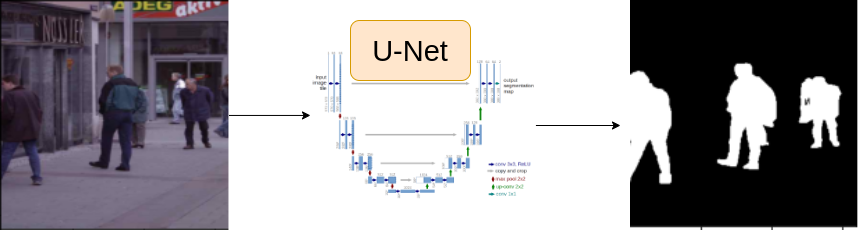

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import helper

import albumentations as A

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv('/content/Human-Segmentation-Dataset-master/train.csv')
row = df.iloc[50]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path) # image is read in BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0 # convert BGR to RGB format

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[50]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path) # image is read in BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0 # convert BGR to RGB format

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

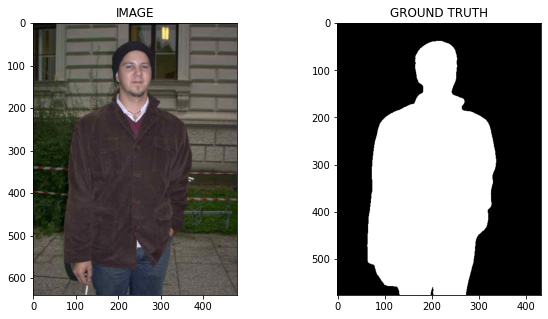

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5),
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # format - (h, w)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0) # we rounded off soo that each pixel in the mask has a value of either 0 or 1

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


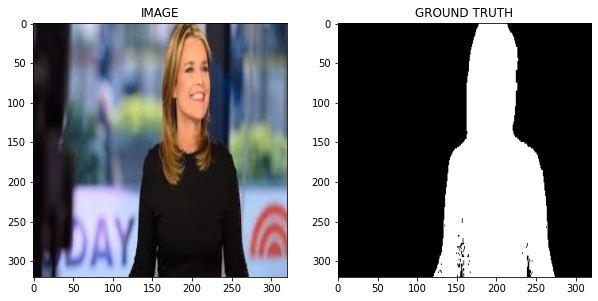

In [ ]:
idx = 60

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f'total number of batches in trainloader : {len(trainloader)}')
print(f'total number of batches in validloader : {len(validloader)}')

total number of batches in trainloader : 15
total number of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, mask = None):
    logits = self.arc(images)

    if mask != None:
      loss1 = DiceLoss(mode = 'binary')(logits, mask)
      loss2 = nn.BCEWithLogitsLoss()(logits, mask)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(dataloader, model, optimizer):

  model.train()
  totalloss = 0

  for images, mask in tqdm(dataloader):
    images = images.to(DEVICE)
    mask = mask.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, mask)
    loss.backward()
    optimizer.step()

    totalloss += loss.item()

  return totalloss / len(dataloader) # average loss

In [ ]:
def eval_fn(dataloader, model):

  model.eval()
  totalloss = 0

  with torch.no_grad():
    for images, mask in tqdm(dataloader):
      images = images.to(DEVICE)
      mask = mask.to(DEVICE)

      logits, loss = model(images, mask)

      totalloss += loss.item()

  return totalloss / len(dataloader) # average loss

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("MODEL SAVED")
    best_valid_loss = valid_loss

  print(f'Epoch : {epoch+1} Train_loss : {train_loss} Valid_loss : {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


MODEL SAVED
Epoch : 1 Train_loss : 0.3391461660464605 Valid_loss : 0.44276948273181915


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


MODEL SAVED
Epoch : 2 Train_loss : 0.32624074319998425 Valid_loss : 0.2570274956524372


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch : 3 Train_loss : 0.26156270603338877 Valid_loss : 0.2673064060509205


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch : 4 Train_loss : 0.2302230010430018 Valid_loss : 0.30552467703819275


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


MODEL SAVED
Epoch : 5 Train_loss : 0.23554005722204843 Valid_loss : 0.21374300122261047


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch : 6 Train_loss : 0.20631750226020812 Valid_loss : 0.26070451363921165


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 7 Train_loss : 0.22354421118895212 Valid_loss : 0.2660903222858906


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 8 Train_loss : 0.24899178445339204 Valid_loss : 0.22070354595780373


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch : 9 Train_loss : 0.2083893487850825 Valid_loss : 0.2293914593756199


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch : 10 Train_loss : 0.15952629446983338 Valid_loss : 0.22372934222221375


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


MODEL SAVED
Epoch : 11 Train_loss : 0.13454842170079548 Valid_loss : 0.17710125260055065


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch : 12 Train_loss : 0.11907151838143666 Valid_loss : 0.1943840105086565


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 13 Train_loss : 0.11783663829167684 Valid_loss : 0.2123429849743843


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch : 14 Train_loss : 0.11398300230503082 Valid_loss : 0.3258836232125759


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch : 15 Train_loss : 0.1571589842438698 Valid_loss : 0.22770065814256668


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 16 Train_loss : 0.1663676624496778 Valid_loss : 0.20379000529646873


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch : 17 Train_loss : 0.14909165898958843 Valid_loss : 0.1875668279826641


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 18 Train_loss : 0.14438915997743607 Valid_loss : 0.21791237592697144


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch : 19 Train_loss : 0.13339377890030543 Valid_loss : 0.2524614781141281


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


MODEL SAVED
Epoch : 20 Train_loss : 0.11204052517811457 Valid_loss : 0.17423060163855553


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 21 Train_loss : 0.12569908499717714 Valid_loss : 0.23535268008708954


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch : 22 Train_loss : 0.10776677827040354 Valid_loss : 0.2248589638620615


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 23 Train_loss : 0.13808977703253428 Valid_loss : 0.20419544354081154


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 24 Train_loss : 0.12560259600480397 Valid_loss : 0.19832196831703186


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

Epoch : 25 Train_loss : 0.12441568424304326 Valid_loss : 0.20087486505508423


# Task 9 : Inference

In [ ]:
idx = 30

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # we unsqueeze to add 1 dim for channel - (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0


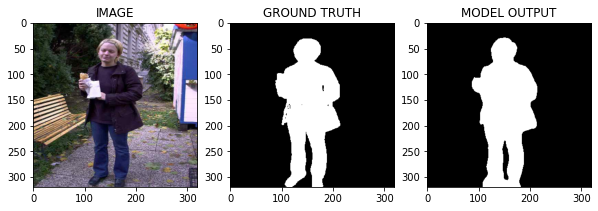

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))